In [1]:
# importanto as bibliotecas necessárias
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import (ensemble, preprocessing, tree)
from sklearn.metrics import(auc, confusion_matrix, roc_auc_score,roc_curve)
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
# IterativeImputer é experimental em algumas versões do sklearn:
# importe o "enable" antes de importar o estimador
from sklearn import model_selection
from sklearn.experimental import enable_iterative_imputer  # deve vir antes DO DE BAIXO
from sklearn.impute import IterativeImputer
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier import ConfusionMatrix #vou chamar quando for usar. Rolou um BO no início. Pois, precisei comendar todas as bibliotecas do yellowbrick até realmente usar
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.model_selection import LearningCurve
#try:                       # EU PODERIA UTILIZAR ESSE CÓDIGO PARA FAZER UMA ANÁLISE EXPLORATÓRIO. ENTRETANTO, DESCOBRI RECENTEMENTE QUE O PROFILING REPORT NÃO SE DÁ BEM COM GRANDES VOLUMES DE DADOS (10M de linhas)
#    from ydata_profiling import ProfileReport              # ENTÃO OPTEI POR USAR A EXPLORAÇÃO MANUAL. MAS ESSE RELATÓRIO AINDA PODE SER ACHADO EM data/preprocessed/profiling_report.html
#except ImportError:
#    try:
#        from pandas_profiling import ProfileReport
#    except ImportError as e:
#        raise ImportError(
#            "Instale 'ydata-profiling' (recomendado) ou 'pandas-profiling' antes de gerar o relatório."
#        ) from e

# Bibliotecas adicionadas durante o coding
#import pandas_profiling

In [2]:
# carregando o dataset
try:
	df = pd.read_csv('https://raw.githubusercontent.com/pandas-dev/pandas/master/doc/data/titanic.csv')
except:
	# Alternative: use seaborn's built-in titanic dataset
	df = pd.read_csv('https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv')
orig_df = df

print(df.shape)
# pclas: classe do passageiro (1 = primeira classe, 2 = segunda classe, 3 = terceira classe)
# survived: 0 = No, 1 = Yes
# name: nome do passageiro
# sex: sexo do passageiro
# age: idade do passageiro em anos
# sibsp: número de irmãos/cônjuges a bordo
# parch: número de pais/filhos a bordo
# ticket: número do bilhete
# fare: tarifa paga pelo passageiro
# cabin: número da cabine
# embarked: porto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton)
# df.boat: bote salva-vida

# organizando o dataset
dir_path='data/'
try:
	# Vou criar uma pasta para conter todas as tabelas e organizar melhor o projeto
	# exist_ok=True      Evita um erro caso o diretório já exista
    os.makedirs('data', exist_ok=True) 
    os.makedirs('data/processed', exist_ok=True)
    os.makedirs('data/preprocessed', exist_ok=True)
    # Salvar o orig_df como um arquivo csv na pasta data
    orig_df.to_csv(os.path.join(dir_path, 'orig_df.csv'), index=False) #tbm faremos o mesmo quando o df for limpo ou fracionado
except Exception as dir_path:
    print(f'Erro ao criar o diretório: {dir_path} e seus itens')

(891, 12)


# Estudo de dados para limpeza dos dados
Aqui queremos trabalho sobre os NaNs ou outliers ou dados inconsistentes. Assim como queremos ermover colunas que possam gerar algum data leakege. Tbm vamos criar colunas dummy ('pd.get_dummies')caso precisemos.
> Data leakage ocorre quando informações do conjunto de dados de teste ou validação vazam para o conjunto de treinamento durante o pré-processamento ou modelagem, ou quando informações do target vazam para as features. 

Nesse processo vamos utilizar duas bibliotecas do pandas 
- pandas_profiling
- pandas_profiling.ProfileReport(df)
Para gerar relatórios em notebooks para vermos detalhes estatísticos descritivos e dos quantis, além de histogramas

In [3]:
#Algumas configurações de bibliotecas e variáveis globais
sns.set(style="whitegrid")

# Importação dos dados
df = pd.read_csv('https://raw.githubusercontent.com/pandas-dev/pandas/master/doc/data/titanic.csv')

#Backup do dataframe original
# organizando o dataset
dir_path='data/'
os.makedirs('data', exist_ok=True) 
os.makedirs('data/processed', exist_ok=True)
os.makedirs('data/preprocessed', exist_ok=True)
# Salvar o orig_df como um arquivo csv na pasta data
df.to_csv(os.path.join(dir_path, 'df.csv'), index=False)


In [4]:
# exibindo as primeiras linhas do dataset
display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Sobre o nosso Dataframe

**pclas:** classe do passageiro (1 = primeira classe, 2 = segunda classe, 3 = terceira classe)

**survived:** 0 = No, 1 = Yes

**name**: nome do passageiro

**sex:** sexo do passageiro

**age:** idade do passageiro em anos

**sibsp:** número de irmãos/cônjuges a bordo

**parch:** número de pais/filhos a bordo

**ticket:** número do bilhete

**fare:** tarifa paga pelo passageiro

**cabin:** número da cabine

**embarked:** porto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton)


In [5]:
# analizando o df de forma truncada as duas colunas iniciais
df.describe().iloc[:, :2]  # Tanto `.loc` quanto `.iloc` são atributos essenciais dos DataFrames do Pandas e ambos são usados ​​para selecionar subconjuntos específicos de dados. Seu propósito é acessar e permitir a manipulação de uma parte específica do DataFrame, em vez do DataFrame inteiro.

# vamos utilizar o isnull para verificar valores nulos
print(f'O somatório de valores nulos no nosso df: {df.isnull().sum()}')
print(f'A média de valores nulos no nosso df: {df.isnull().mean()}')

# analise de algumas das linhas com dados ausentes com boleanos
mask = df.isnull().any(axis=1)
print(mask.sum(), "linhas com pelo menos um NaN")
display(df[mask].head())           # inspeciona as linhas com NaN
print(df.isnull().sum()[lambda s: s>0])  # colunas com NaNs e suas contagens
print((df.isnull().mean()*100).sort_values(ascending=False).head())  # % de NaNs por coluna
#mask.head() #linhas
#df[mask].body.head()

O somatório de valores nulos no nosso df: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
A média de valores nulos no nosso df: PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
708 linhas com pelo menos um NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


Age         177
Cabin       687
Embarked      2
dtype: int64
Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Name            0.000000
dtype: float64


## CASO, ONDE USAMOS O YDATA_PROFILING

código copiável abaixo com base na biblioteca relacionada (comentada)

Gerar relatório de perfil (tenta ydata_profiling, senão usa pandas_profiling)

Código
```python
#report = ProfileReport(df)
# Mostrar no notebook (iframe) - to_notebook_iframe() já cuida da exibição no Jupyter
try:
    report.to_notebook_iframe()
except Exception:
    # Caso a exibição inline falhe, escrevemos o arquivo HTML e informamos o caminho
    report.to_file(os.path.join(dir_path, "preprocessed", "profile_report.html"))
    print(f"Relatório salvo em {os.path.join(dir_path, 'preprocessed', 'profile_report.html')}")
else:
    # também salvar em HTML
    report.to_file(os.path.join(dir_path, "preprocessed", "profile_report.html"))
```
Agora contínuemos...

In [6]:
#análise exploratória inicial dos dados 1#
df.info()                                  #Estatísticas descritivas
df['Survived'].value_counts(normalize=True)     #Proporção de sobreviventes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#análise exploratória inicial dos dados 2#
df.isnull().mean().sort_values(ascending=False) #Análise de Qualidade dos Dados

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Name           0.000000
Pclass         0.000000
Survived       0.000000
Sex            0.000000
Parch          0.000000
SibSp          0.000000
Fare           0.000000
Ticket         0.000000
dtype: float64

In [9]:
df['Survived'].mean()

np.float64(0.3838383838383838)

# Alguns insights
Em termos de valores nulos, quando comparamos ao nosso target, o dataset é desbalanceado, com mais mortes do que sobreviventes

'Cabin' tem muitos valores ausentes (>70%)
'Age' tem valores ausentes relevantes
'Embarked' tem poucos valores ausentes


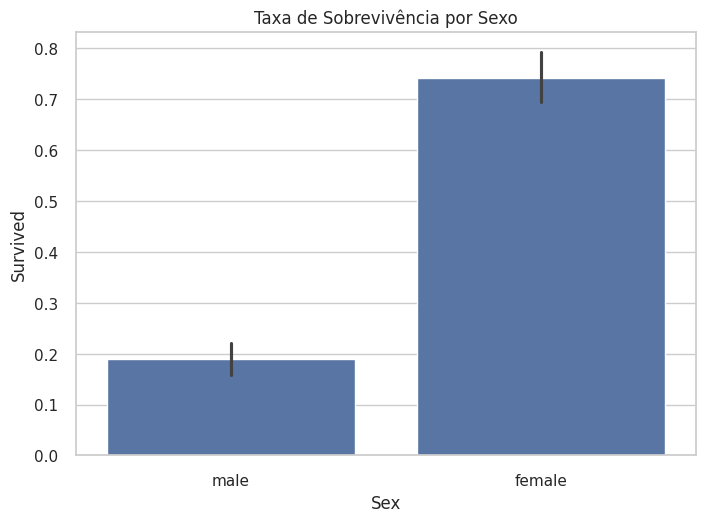

In [10]:
# Gerando alguns gráficos
# Taxa de sobrevivência por sexo
sns.barplot(data=df, x="Sex", y="Survived")
plt.title("Taxa de Sobrevivência por Sexo")
plt.show()
plt.close()

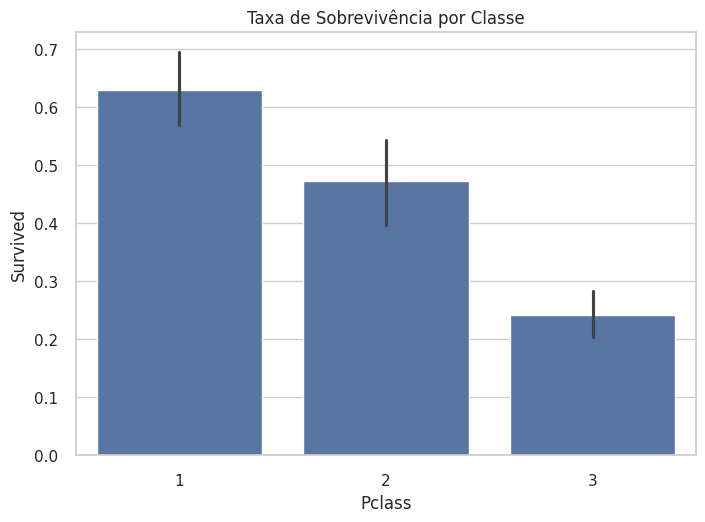

In [11]:
# Taxa de sobrevivência por classe
sns.barplot(data=df, x="Pclass", y="Survived")
plt.title("Taxa de Sobrevivência por Classe")
plt.show()
plt.close()

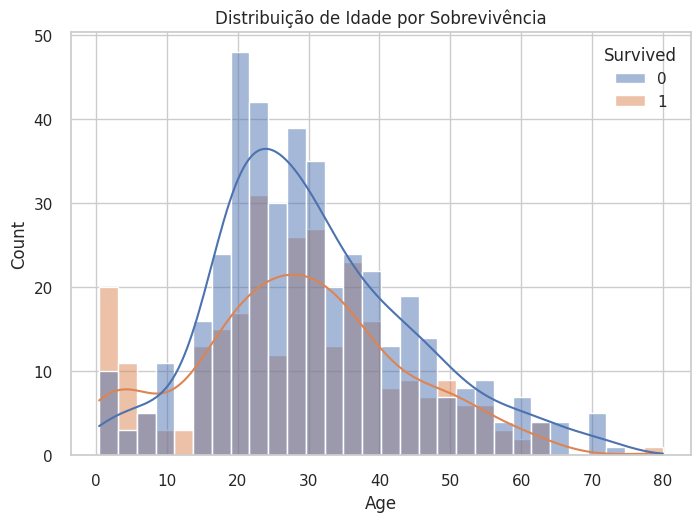

In [12]:
# Distribuição de idade por sobrevivência
sns.histplot(data=df, x="Age", hue="Survived", bins=30, kde=True)
plt.title("Distribuição de Idade por Sobrevivência")
plt.show()

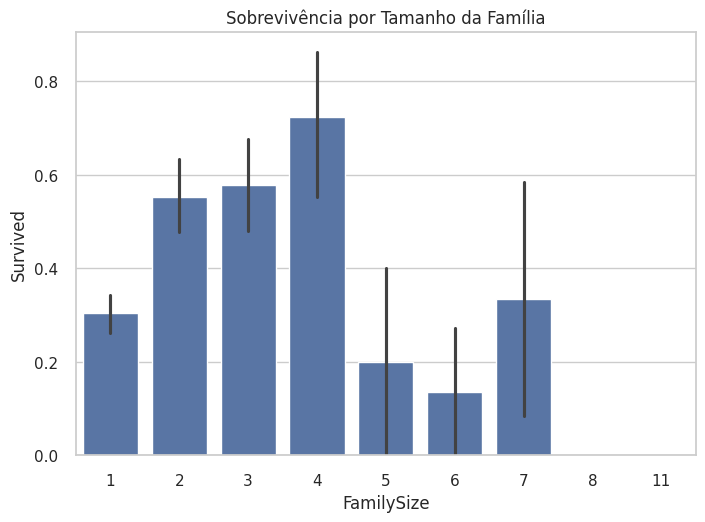

In [13]:
# Família a Bordo (SibSp + Parch)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

sns.barplot(data=df, x="FamilySize", y="Survived")
plt.title("Sobrevivência por Tamanho da Família")
plt.show()

In [14]:
df_transformed = df.copy()

In [15]:
# categorização para limpeza
# defina o target antes de remover a coluna
print(f'Os tipos das colunas até então: /n{df_transformed.dtypes}/n')

print('\n') ## Tentando deixar o output mais legível
print('\n')

if 'Name' in df_transformed.columns:
    name= df_transformed['Name']
    print(f'a cabeça do nosso objeto names: \n{name.head(3)}\n')
else:
    print("A coluna do objeto Name está presente somente no dataframe original.")
#removendo colunas que não serão usadas ou podem gerar viés no modelo

print('\n')  ## Tentando deixar o output mais legível
print('\n')

df_transformed=df_transformed.drop(columns=["Name","Ticket", "Cabin"])   # Essas colunas não nos dizem muito para o modelo
# logo vamos criar uma coluna "dummy"
df_transformed=pd.get_dummies(df_transformed)  # ou # df_transformed=pd.get_dummies(df_transformed,drop_first=True) #para evitar a dummy trap... No caso as colunas male_sex e famale são inversos perfeitos
df_transformed=df_transformed.drop(columns=["Sex_female"])  # removendo uma das colunas dummies para evitar dummy trap
print(f'Nossas colunas são com os dummies aplicados: {df_transformed.columns}') 

y = df_transformed['Survived']   #Estou em dúvida se criaria outra coluna "dead" como target alternativo. Se pensarmos em Boleanos, seriam antônimos
X = df_transformed.drop(columns="Survived")

Os tipos das colunas até então: /nPassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
FamilySize       int64
dtype: object/n




a cabeça do nosso objeto names: 
0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss Laina
Name: Name, dtype: object





Nossas colunas são com os dummies aplicados: Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [16]:
# Separação de amostra #amostra_para_validação_do_modelo
# scikit-learn para separar 30% para os testes


X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

#Impotação dos dados
##como a coluna idade tem valores ausentes. Vamos imputar udade a partir dos valores numéricos apenas no conjunto de treinamento, e então

In [22]:
# Colunas numéricas a imputar (use nomes como strings)
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# verificar quais colunas realmente existem nos dataframes (evita KeyError)
num_cols = [c for c in num_cols if c in X_train.columns]

imputer = IterativeImputer(random_state=0)
X_train.loc[:, num_cols] = imputer.fit_transform(X_train[num_cols])
X_test.loc[:, num_cols] = imputer.transform(X_test[num_cols])

# preencher possíveis NaNs restantes com a mediana do conjunto de treino (aplicado às colunas numéricas)
# meds = X_train[num_cols].median() #leakage !!!!! Fazemento de dados da treino para o teste
# X_train.loc[:, num_cols] = X_train[num_cols].fillna(meds)
# X_test.loc[:, num_cols] = X_test[num_cols].fillna(meds)

In [23]:
X_train.isnull().sum(), X_test.isnull().sum()

(PassengerId    0
 Pclass         0
 Age            0
 SibSp          0
 Parch          0
 Fare           0
 FamilySize     0
 Sex_male       0
 Embarked_C     0
 Embarked_Q     0
 Embarked_S     0
 dtype: int64,
 PassengerId    0
 Pclass         0
 Age            0
 SibSp          0
 Parch          0
 Fare           0
 FamilySize     0
 Sex_male       0
 Embarked_C     0
 Embarked_Q     0
 Embarked_S     0
 dtype: int64)

In [ ]:
# Antes do StandardScaler
for c in X_train[num_cols].columns:                 
    print(c, X_train[c].mean(), X_train[c].std()) 

Pclass 2.3418940609951844 0.81994487012546
Age 28.77154159975717 13.739800540129066
SibSp 0.5762439807383628 1.2162672925277873
Parch 0.3868378812199037 0.8076921895327202
Fare 31.840729534510434 51.02737165510575


In [ ]:
#normalização dos dados
## Este processo será importante para nosso modelo ter uma melhor performance.
sca = preprocessing.StandardScaler()                # o objetivo do StandardScaler é deixar a média como 0 e o desvio padrão como 1

# Escalar apenas as colunas numéricas selecionadas no lugar, preservando as demais colunas (dummies)
if num_cols:
    X_train.loc[:, num_cols] = sca.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = sca.transform(X_test[num_cols])


# Conferir tipos e shapeprint("Numeric cols scaled:", num_cols)
print("X_train.shape:", X_train.shape)

X_train.shape: (623, 11)


/tmp/ipykernel_47805/607474333.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.63788124  0.80326712  0.80326712 -0.41730706 -0.41730706 -1.63788124
 -0.41730706  0.80326712  0.80326712 -0.41730706 -1.63788124 -0.41730706
  0.80326712  0.80326712 -1.63788124  0.80326712 -0.41730706  0.80326712
  0.80326712  0.80326712 -0.41730706  0.80326712  0.80326712  0.80326712
  0.80326712  0.80326712  0.80326712 -1.63788124  0.80326712 -0.41730706
  0.80326712  0.80326712  0.80326712 -1.63788124 -0.41730706 -0.41730706
  0.80326712 -1.63788124  0.80326712  0.80326712 -1.63788124 -0.41730706
 -1.63788124 -0.41730706 -0.41730706  0.80326712  0.80326712 -0.41730706
  0.80326712 -0.41730706 -0.41730706  0.80326712 -1.63788124  0.80326712
 -1.63788124  0.80326712 -0.41730706  0.80326712  0.80326712  0.80326712
  0.80326712  0.80326712  0.80326712  0.80326712  0.80326712 -0.41730706
 -0.41730706 -1.63788124 -1.63788124 -0.41

In [ ]:
# Depois do StandardScaler
for c in X_train[num_cols].columns:
    print(c, X_train[c].mean(), X_train[c].std()) 

Pclass 2.5376526277146434e-16 1.000803535686101
Age 2.480626725968247e-16 1.000803535686101
SibSp -3.991813122247754e-17 1.000803535686101
Parch -5.702590174639648e-18 1.0008035356861007
Fare -2.851295087319824e-18 1.000803535686101


In [ ]:
#Refatoração (Eu poderia chamarestars funções no lugar do códigos acimas
## A medida que o ML for evoluindo, vamos precisar realizar ajustes e até mesmo importar o original dataset novamente para refinar o modelo.
## Faremos duas funções para o processo
def tweak_titanic(df):
    """Remove colunas que causam leakage e converte categóricas em dummies (drop_first=True).
    Retorna um DataFrame somente com colunas numéricas e dummies.
    """
    df = df.copy()
    drop_cols = [c for c in ["Name", "Ticket", "Survived", "Cabin"] if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    df = pd.get_dummies(df, drop_first=True)
    return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    """Separa X/y, divide treino/teste, imputa colunas numéricas e (opcional) escala colunas em std_cols.
    Retorna X_train, X_test, y_train, y_test.
    """
    if y_col not in df.columns:
        raise ValueError(f"{y_col} não encontrado em df.columns")

    y = df[y_col]
    X = df.drop(columns=y_col)

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, stratify=y, random_state=42
    )

    # Colunas numéricas candidatas (ajuste conforme seu df)
    num_candidates = ["Pclass", "Age", "SibSp", "Sibsp", "Parch", "Fare"]
    num_cols = [c for c in num_candidates if c in X_train.columns]

    if num_cols:
        imputer = IterativeImputer(random_state=0)
        X_train.loc[:, num_cols] = imputer.fit_transform(X_train[num_cols])
        X_test.loc[:, num_cols] = imputer.transform(X_test[num_cols])

    # Normalizar colunas passadas em std_cols (aceita string "a,b,c" ou lista)
    if std_cols:
        if isinstance(std_cols, str):
            std_cols = [c.strip() for c in std_cols.split(",")]
        std_cols = [c for c in std_cols if c in X_train.columns]
        if std_cols:
            std = preprocessing.StandardScaler()
            X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
            X_test.loc[:, std_cols] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test
    # Escalar colunas passadas em std_cols (somente se existirem)

In [28]:
#modelo_de_base
#uma_base_realmente_simples_que_o_modelo_usara_como_comparador
from sklearn.dummy import DummyClassifier

bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test) #nos_dará_nossa_precisao

from sklearn import metrics
metrics.precision_score(y_test, bm.predict(X_test))



#familias
#Neste_projeto_vamos_comparar_pontuações_AUC_e_o_desvio_padão_usando_a_validação_cruzadak_fold
X=pd.concat([X_train, X_test])
y=pd.concat([y_train, y_test])

models = [
    DummyClassifier(),
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(random_state=42),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(probability=True),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),

    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),

]

## Cross-validation stratificada com 10 folds
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)    

for m in models:
    try:
        s = cross_val_score(m, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1, error_score='raise')
        print(f'{m.__class__.__name__:22} AUC: {s.mean():.3f} STD: {s.std():.2f}')  #Por que usar o AUC em vez da Acurácia? A acurácia pode ser enganosa se os seus dados estiverem desbalanceados.
    except Exception as e:
        print(f'{m.__class__.__name__:22} FAILED!!!!!: {e}')

/home/tiago-ubunto/Documentos/Estudo/ti_estudo/meus-projetos/Titanic/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.835 STD: 0.05
DecisionTreeClassifier AUC: 0.737 STD: 0.03
KNeighborsClassifier   AUC: 0.489 STD: 0.05
GaussianNB             AUC: 0.800 STD: 0.05
SVC                    AUC: 0.764 STD: 0.06
RandomForestClassifier AUC: 0.854 STD: 0.06
XGBClassifier          AUC: 0.853 STD: 0.05


/home/tiago-ubunto/Documentos/Estudo/ti_estudo/meus-projetos/Titanic/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:08:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tiago-ubunto/Documentos/Estudo/ti_estudo/meus-projetos/Titanic/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:08:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tiago-ubunto/Documentos/Estudo/ti_estudo/meus-projetos/Titanic/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:08:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tiago-ubunto/Documentos/Estudo/ti_estudo/meus-projetos/Titanic/.venv/lib/python3.12/site-packages/xgboost/training.py:199: User

In [29]:
model=LogisticRegression()
model.fit(X_train, y_train)

/home/tiago-ubunto/Documentos/Estudo/ti_estudo/meus-projetos/Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [33]:
y_pred=model.predict(X_test)
print(y_pred)
y_pred_prob=model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
print(y_pred_prob)

[0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1
 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 1 0 1 0 0 0 0 0]
[0.15267269 0.22131473 0.15022695 0.89555303 0.72597001 0.9235097
 0.67020139 0.08699235 0.75029083 0.91674754 0.30835006 0.06777134
 0.45205249 0.15471869 0.18952167 0.94282464 0.29617735 0.68951213
 0.26944857 0.30083394 0.11795653 0.41048725 0.57076504 0.14565287
 0.11300698 0.07671711 0.46620389 0.23272943 0.07841052 0.55950295
 0.15602776 0.62122696 0.51859856 0.57854201 0.1393275  0.14086187
 0.44221813 0.6645246  0.94815531 0.11607441 0.1853554

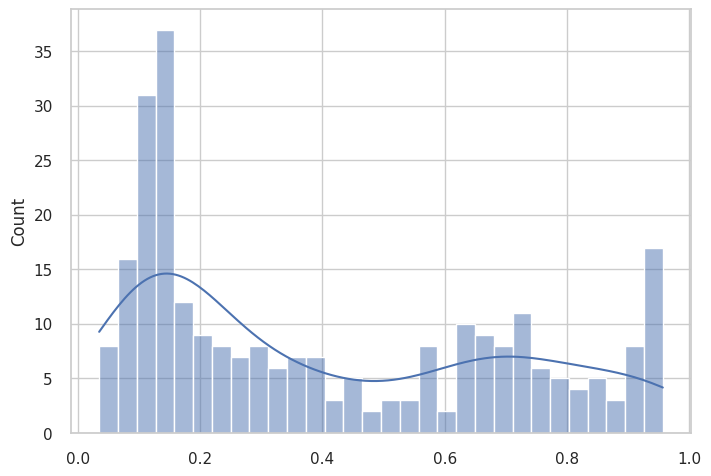

In [ ]:
sns.histplot(y_pred_prob, bins=30, kde=True)
plt.show()

In [21]:
# Criando o modulo
## Usaremos um classificador de random forest
rf=ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [22]:
#Avaliação de modelo
print(f'A média da precisão da precisão:{rf.score(X_test, y_test)}')
print(f'A média da precisão:{metrics.precision_score(y_test, rf.predict(X_test))}')

for col, val in sorted(
    zip(X_train.columns, rf.feature_importances_,), key=lambda x: x[1], reverse=True,)[:5]:
    print(f'Como cada atributo interfere? \n{col:10}{val:10.3f}') # Este processo é observado atravez do calculo observando o aumento no erro



A média da precisão da precisão:0.8097014925373134
A média da precisão:0.8409090909090909
Como cada atributo interfere? 
Sex_male       0.236
Como cada atributo interfere? 
Fare           0.184
Como cada atributo interfere? 
PassengerId     0.183
Como cada atributo interfere? 
Age            0.180
Como cada atributo interfere? 
Pclass         0.070


In [23]:
#Otimizando o modelo
## Preciso estudar 'grid_search' do sklearn.model_selection para otimizar os hiperparâmetros do modelo

/home/tiago-ubunto/Documentos/Estudo/ti_estudo/meus-projetos/Titanic/.venv/lib/python3.12/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


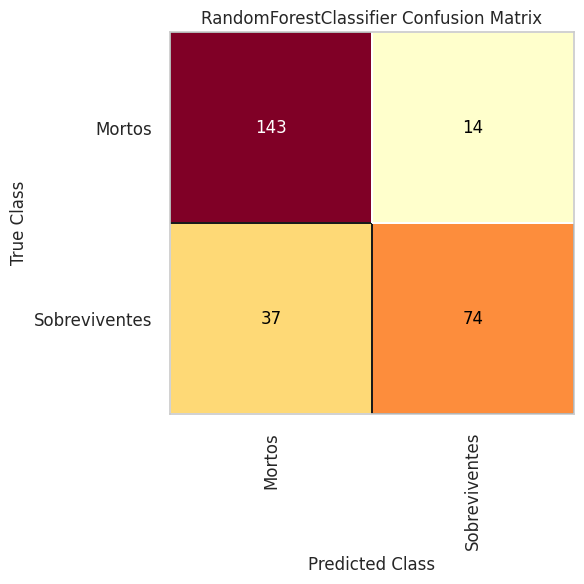

In [24]:
# Matriz de confusão
## Essa matriz é um complemento importante para avaliar o desempenho do modelo de classificação. Uma forma auternativa de visualizar os resultados da classificação é através de uma matriz de confusão, que mostra o número de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos produzidos pelo modelo.
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

#Dicionário de mapeamento
mapping={0: "Mortos", 1: "Sobreviventes"}
fig, ax = plt.subplots(figsize=(6,6))
cm_viz = ConfusionMatrix(rf, classes=["Mortos", "Sobreviventes"], ax=ax,
    force_model=True)
cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig('data/processed/confusion_matrix.png', dpi=300, bbox_inches="tight")
plt.close()


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (12).

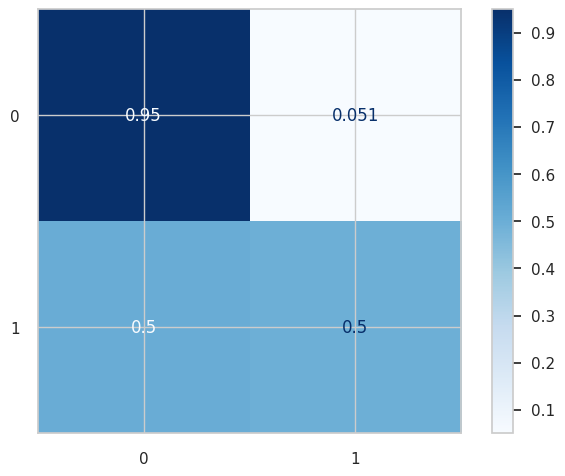

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
from sklearn import svm

classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)
disp = ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test,
    y_test,
    display_labels=df,
    cmap=plt.cm.Blues,
    normalize='true',
    )
disp.ax_.set_title("Matriz de Confusão com normalização")

print('Matriz de Confusão com normalização')
print(disp.confusion_matrix)
plt.show()